# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

### Data Load

In [2]:
paths = glob.glob("./data/*")
paths

['./data\\movies_test.csv',
 './data\\movies_train.csv',
 './data\\submission.csv']

In [3]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [4]:
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
train.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [8]:
test.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [9]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [10]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

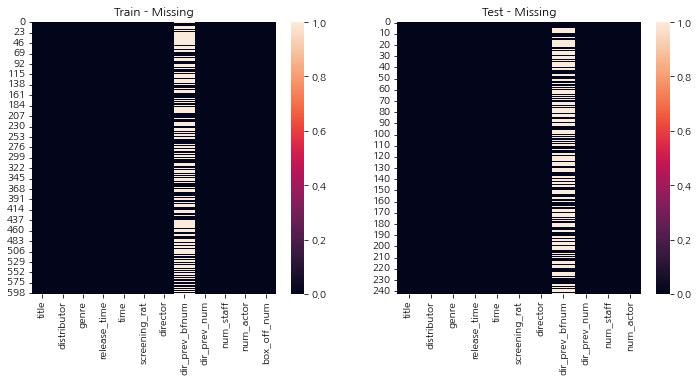

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
_ = sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train - Missing")
_ = sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test - Missing")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [12]:
train["distributor"] = train["distributor"].str.replace("\(|주|\)", "", regex=True)
test["distributor"] = test["distributor"].str.replace("\(|주|\)", "", regex=True)

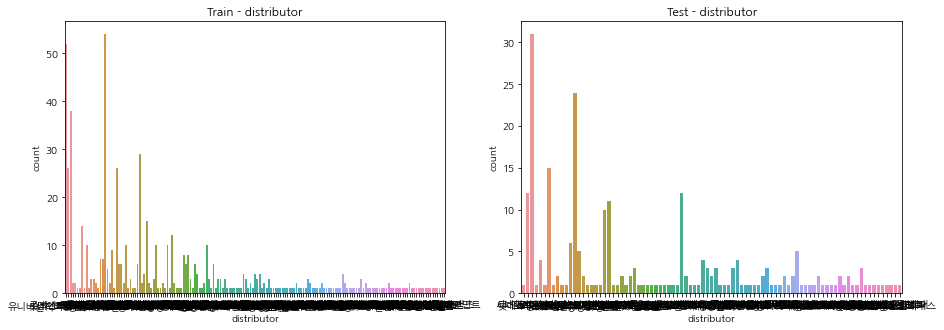

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=train["distributor"], ax=ax[0]).set_title("Train - distributor")
sns.countplot(x=test["distributor"], ax=ax[1]).set_title("Test - distributor")
plt.show()

In [14]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

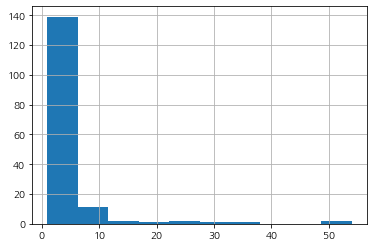

In [15]:
_ = train["distributor"].value_counts().hist()

In [16]:
def distributor_band(col, d=dict(train["distributor"].value_counts())):
    try:
        if d[col]<=15: return "소형"
        else: return "중대형"
    except:
        return "소형"

In [17]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [18]:
train["distributor"] = train["distributor"].apply(distributor_band)
test["distributor"] = test["distributor"].apply(distributor_band)

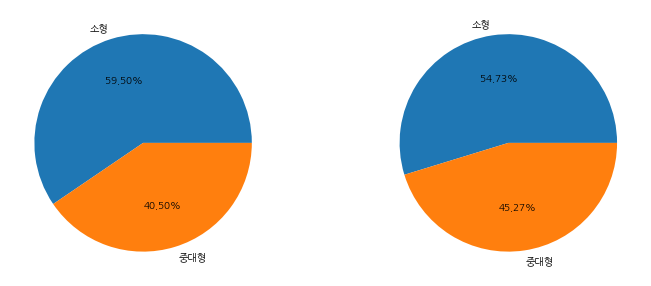

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [20]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [21]:
rank = {'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5, '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12}

In [22]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [23]:
train.drop(columns="genre", axis=1, inplace=True)
test.drop(columns="genre", axis=1, inplace=True)

### release_time: 개봉일

In [24]:
train["release_time"] = pd.to_datetime(train["release_time"])
test["release_time"] = pd.to_datetime(test["release_time"])

In [25]:
target = [train, test]

for t in target:
    t["year"] = t["release_time"].dt.year
    t["month"] = t["release_time"].dt.month
    t["day"] = t["release_time"].dt.day
    t["dayofweek"] = t["release_time"].dt.dayofweek

In [26]:
train.drop(columns="release_time", axis=1, inplace=True)
test.drop(columns="release_time", axis=1, inplace=True)

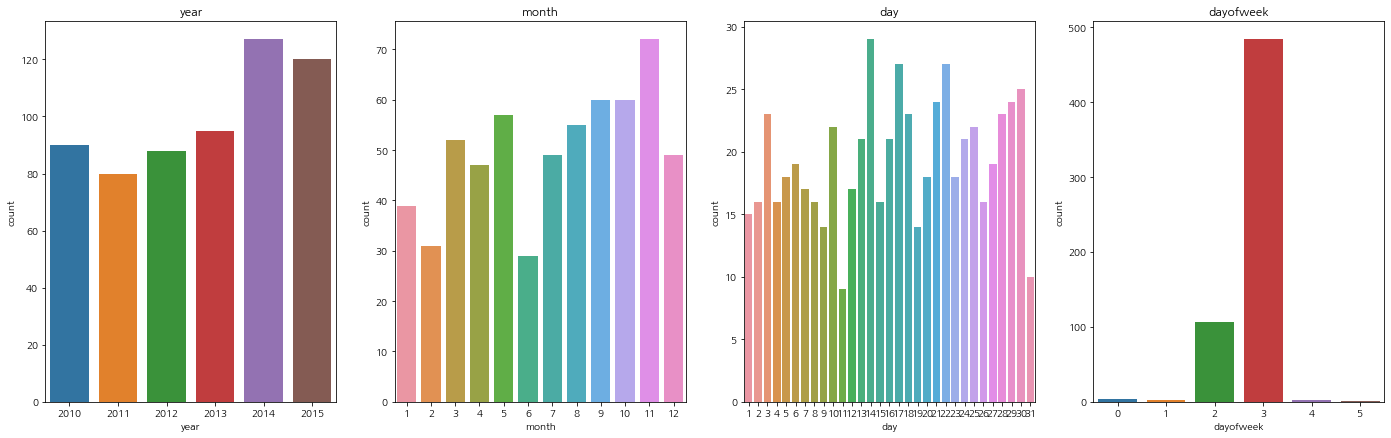

In [27]:
date = ["year", "month", "day", "dayofweek"]

fig, ax = plt.subplots(1, len(date), figsize=(24, 7))
for col_name, ax in zip(date, ax):
    sns.countplot(data=train, x=col_name, ax=ax).set_title(f"{col_name}")
plt.show()

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [28]:
train.drop(columns=["title", "director"], axis=1, inplace=True)
test.drop(columns=["title", "director"], axis=1, inplace=True)

In [29]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [30]:
train = pd.get_dummies(train, columns=["distributor", "screening_rat"])
test = pd.get_dummies(test, columns=["distributor", "screening_rat"])

In [31]:
label = "box_off_num"
features = train.columns.tolist()
features.remove(label)
features

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

### Log Scale

In [32]:
train["num_actor"] = np.log1p(train["num_actor"])
test["num_actor"] = np.log1p(test["num_actor"])

In [33]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [34]:
test.shape

(243, 16)

### Random Forest

In [35]:
reg_rf = RandomForestRegressor()

pred_rf = reg_rf.fit(X_train, y_train).predict(X_val)

print(f"rmse: {np.sqrt(mean_squared_error(y_val, pred_rf))}")


rmse: 1377636.6138653848


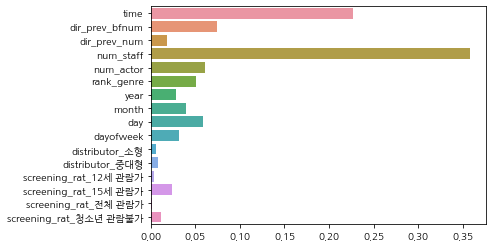

In [37]:
_ = sns.barplot(x=reg_rf.feature_importances_, y=reg_rf.feature_names_in_)

### XGBoost

In [38]:
reg_xgb = XGBRegressor()

pred_xgb = reg_xgb.fit(X_train, y_train).predict(X_val)

print(f"rmse: {np.sqrt(mean_squared_error(y_val, pred_xgb))}")


rmse: 1444161.2032999645


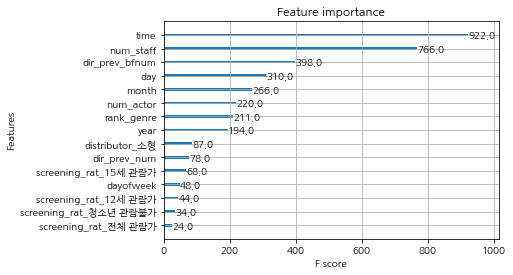

In [39]:
_ = xgb.plot_importance(reg_xgb)

### LightGBM

In [40]:
reg_lgbm = LGBMRegressor()

pred_lgbm = reg_lgbm.fit(X_train, y_train).predict(X_val)

print(f"rmse: {np.sqrt(mean_squared_error(y_val, pred_xgb))}")


rmse: 1444161.2032999645


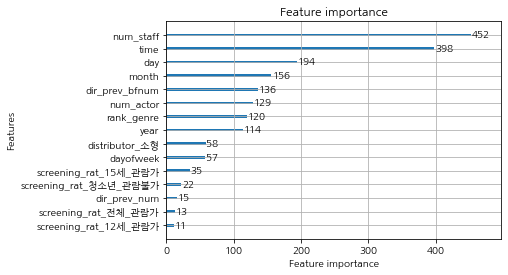

In [41]:
_ = lgbm.plot_importance(reg_lgbm)

## Submit

In [43]:
sub = pd.read_csv(paths[2])
sub.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [46]:
pred = (0.6*reg_rf.predict(X_val)) + (0.2*reg_xgb.predict(X_val)) + (0.2*reg_lgbm.predict(X_val))
print(f"rmse: {np.sqrt(mean_squared_error(y_val, pred))}")

rmse: 1368430.7286695272


In [47]:
pred = (0.6*reg_rf.predict(test)) + (0.2*reg_xgb.predict(test)) + (0.2*reg_lgbm.predict(test))

In [49]:
sub["box_off_num"] = pred

In [50]:
sub.to_csv("sub_rmse_1368.csv", index=False)